In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz, simps, cumtrapz

from scipy.interpolate import interp1d

#from labellines import labelLine, labelLines
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Расчет

Некоторые константы

In [2]:
Q_EC_127Xe=0.662 #in MeV
Z_127Xe=54

g_a_g_v=1.297 #ratio of vector and axial coupling constants

BS05_OP_pep_ampl=1.42e8
pep_en=1.442 #MeV

Be384_en = 0.384 #Mev 
Be862_en = 0.862 #Mev

S_n = 7.246 #энергия отрыва нейтрона
S_2n = 17.02
total_GT = 53.54
#total_GT = 63

Функция для расчета порога реакции

In [3]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [4]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [5]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [6]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-function from Numerical Tables for Beta-Decay and Electron Capture

Ферми функия из оцифрованных немецких таблиц. Считываем данные

In [7]:
Fermi_func_new_data = pd.read_excel('../../fermi_func_tables/from_1968/Z_54.ocr.xls', 
                                    parse_cols="A,B", decimal='.')
Fermi_func_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
p       48 non-null float64
F0L0    48 non-null float64
dtypes: float64(2)
memory usage: 848.0 bytes


In [8]:
Fermi_func_new_data.head()

,p,F0L0
0,0.1,68.550
1,0.2,34.627
2,0.3,23.465
3,0.4,17.995
4,0.5,14.807


Функция для расчета интерполированного значения. В таблице дана зависимость от импульса вылетающего электрона. Переводим ее в зав-ть от энергии электрона

In [9]:
e_e3 = np.sqrt( np.square( Fermi_func_new_data['p'].values ) + 1 ) #энергия вылетающего электрона
def num_tables_func(x):
    #x in units of mc^2
    return np.interp(x=x, xp=e_e3, fp=Fermi_func_new_data['F0L0'].values )

### BS05_OP flux

In [10]:
BS05OP_Be = 4.84e9
BS05OP_pp = 5.99e10
BS05OP_pep = 1.42e8
BS05OP_hep = 7.93e3
BS05OP_B = 5.69e6
BS05OP_N = 3.07e8
BS05OP_0 = 2.33e8
BS05OP_F = 5.84e6

In [11]:
BP98_Be = 4.80e9
BP98_pp = 5.94e10
BP98_pep = 1.39e8
BP98_hep = 2.10e3
BP98_B = 5.15e6 
BP98_N = 6.05e8
BP98_0 = 5.32e8
BP98_F = 6.33e6

In [12]:
BP98_OPAL92_Be = 4.94e9
BP98_OPAL92_pp = 5.92e10
BP98_OPAL92_pep = 1.39e8
BP98_OPAL92_hep = 2.08e3
BP98_OPAL92_B = 5.44e6 
BP98_OPAL92_N = 6.25e8
BP98_OPAL92_0 = 5.52e8
BP98_OPAL92_F = 6.59e6

In [13]:
#B16-GS98 - high metallicity
B16_GS98_Be = 4.93e9
B16_GS98_pp = 5.98e10
B16_GS98_pep = 1.44e8
B16_GS98_hep = 7.98e3
B16_GS98_B = 5.46e6 
B16_GS98_N = 2.78e8
B16_GS98_0 = 2.05e8
B16_GS98_F = 5.29e6

In [14]:
#B16-AGSS09met - low metallicity
B16_AGSS09met_Be = 4.50e9
B16_AGSS09met_pp = 6.03e10
B16_AGSS09met_pep = 1.46e8
B16_AGSS09met_hep = 8.25e3
B16_AGSS09met_B = 4.50e6 
B16_AGSS09met_N = 2.04e8
B16_AGSS09met_0 = 1.44e8
B16_AGSS09met_F = 3.26e6

In [15]:
#fluxes_df = pd.DataFrame()

In [16]:
step_all_fluxes = 0.001 #MeV
Energy_all_fluxes = np.arange(0,20,step_all_fluxes)

In [17]:
def return_flux(pp_ampl, hep_ampl, B_ampl, N_ampl, O_ampl, F_ampl, 
                energy_list = Energy_all_fluxes):
    pp = pd.read_excel('../Solar_neutrino_flux/pp.xls')
    b8 = pd.read_excel('../Solar_neutrino_flux/b8.xls')
    hep = pd.read_excel('../Solar_neutrino_flux/hep.xls')
    n13 = pd.read_excel('../Solar_neutrino_flux/n13.xls')
    o15 = pd.read_excel('../Solar_neutrino_flux/o15.xls')
    f17 = pd.read_excel('../Solar_neutrino_flux/f17.xls')

    flux = {
        'pp':np.interp(x=Energy_all_fluxes, xp=pp['Energy'].values, 
                       fp=pp['Probability'].values * pp_ampl ),
        'b8':np.interp(x=Energy_all_fluxes, xp=b8['Energy'].values, 
                       fp=b8['Probability'].values * B_ampl ),
        'hep':np.interp(x=Energy_all_fluxes, xp=hep['Energy'].values, 
                       fp=hep['Probability'].values * hep_ampl ),
        'n13':np.interp(x=Energy_all_fluxes, xp=n13['Energy'].values, 
                       fp=n13['Probability'].values * N_ampl ),
        'o15':np.interp(x=Energy_all_fluxes, xp=o15['Energy'].values, 
                       fp=o15['Probability'].values * O_ampl ),
        'f17':np.interp(x=Energy_all_fluxes, xp=f17['Energy'].values, 
                       fp=f17['Probability'].values * F_ampl ),
    }
    return flux

In [18]:
BS05OP_flux = return_flux(pp_ampl=BS05OP_pp, 
                          hep_ampl=BS05OP_hep,
                          B_ampl=BS05OP_B,
                          N_ampl=BS05OP_N,
                          O_ampl=BS05OP_0,
                          F_ampl=BS05OP_F)

BP98_flux = return_flux(pp_ampl=BP98_pp, 
                          hep_ampl=BP98_hep,
                          B_ampl=BP98_B,
                          N_ampl=BP98_N,
                          O_ampl=BP98_0,
                          F_ampl=BP98_F)

BP98_OPAL92_flux = return_flux(pp_ampl=BP98_OPAL92_pp, 
                          hep_ampl=BP98_OPAL92_hep,
                          B_ampl=BP98_OPAL92_B,
                          N_ampl=BP98_OPAL92_N,
                          O_ampl=BP98_OPAL92_0,
                          F_ampl=BP98_OPAL92_F)

B16_GS98_flux = return_flux(pp_ampl=B16_GS98_pp, 
                          hep_ampl=B16_GS98_hep,
                          B_ampl=B16_GS98_B,
                          N_ampl=B16_GS98_N,
                          O_ampl=B16_GS98_0,
                          F_ampl=B16_GS98_F)

B16_AGSS09met_flux = return_flux(pp_ampl=B16_AGSS09met_pp, 
                          hep_ampl=B16_AGSS09met_hep,
                          B_ampl=B16_AGSS09met_B,
                          N_ampl=B16_AGSS09met_N,
                          O_ampl=B16_AGSS09met_0,
                          F_ampl=B16_AGSS09met_F)

In [19]:
#!pip install matplotlib-label-lines

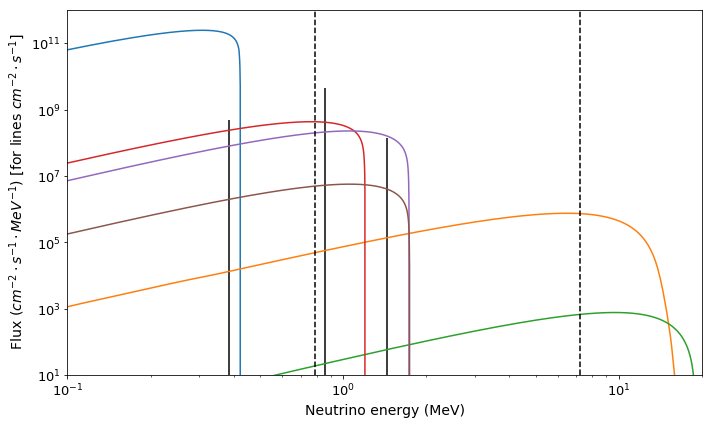

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

ax.tick_params(axis="y", labelsize=13)
ax.tick_params(axis="x", labelsize=13)

ax.plot(Energy_all_fluxes, BS05OP_flux['pp'], label='pp')
ax.plot(Energy_all_fluxes, BS05OP_flux['b8'], label='8B')
ax.plot(Energy_all_fluxes, BS05OP_flux['hep'], label='hep')
ax.plot(Energy_all_fluxes, BS05OP_flux['n13'], label='13N')
ax.plot(Energy_all_fluxes, BS05OP_flux['o15'], label='15O')
ax.plot(Energy_all_fluxes, BS05OP_flux['f17'], label='17F')

ax.axvline(Q_EC_127Xe+0.125, c='k', ls='--')
ax.axvline(S_n, c='k', ls='--')
#ax.text(Q_EC_127Xe+0.05, 10**11, 'Q=232.6 KeV', rotation=90, fontsize=12)

ax.vlines(pep_en, 0, BS05OP_pep, label='pep')
ax.vlines(Be384_en, 0, BS05OP_Be*0.103, label='7Be 384 KeV')
ax.vlines(Be862_en, 0, BS05OP_Be*(1-0.103), label='7Be 862 KeV')

ax.set_xlabel('Neutrino energy (MeV)', fontsize=14)
ax.set_ylabel(' Flux ($cm^{-2}\cdot s^{-1}\cdot MeV^{-1}$) [for lines $cm^{-2}\cdot s^{-1}$]', fontsize=14)

ax.set_yscale('log')
ax.set_xscale('log')
my_yticks = [ 10**(1), 10**(2), 10**(3), 10**(4), 10**(5), 10**(6), 10**(7), 10**(8),
            10**(9), 10**(10), 10**(11), 10**(12)]
#ax.set_yticks(my_yticks)

#ax.set_xticks(np.arange(0,21,1))

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(True)

ax.get_yaxis().set_major_formatter(formatter)

def myticks(x,pos):
    if x == 0: return "$0$"
    exponent = int(np.log10(x))
    return r"$10^{{ {:2d} }}$".format(exponent)

ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(myticks))

#labelLines(plt.gca().get_lines(), zorder=2.5)

#my_yticks_str = [str(elem) for elem in my_yticks]
#ax.set_yticklabels(my_yticks_str)
#ax.set_xticks(np.arange(0,21,1))

ax.set_ylim(10**(1), 10**(12))
ax.set_xlim(10**(-1), 20)
#ax.legend(fontsize=13, loc='upper right')
fig.tight_layout()
#fig.savefig('solar_flux_for_127I.png', format='png', dpi=500)

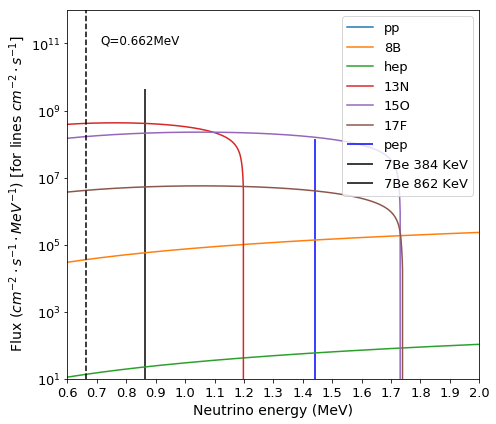

In [21]:
fig, ax = plt.subplots(figsize=(7,6))

ax.tick_params(axis="y", labelsize=13)
ax.tick_params(axis="x", labelsize=13)

ax.plot(Energy_all_fluxes, BS05OP_flux['pp'], label='pp')
ax.plot(Energy_all_fluxes, BS05OP_flux['b8'], label='8B')
ax.plot(Energy_all_fluxes, BS05OP_flux['hep'], label='hep')
ax.plot(Energy_all_fluxes, BS05OP_flux['n13'], label='13N')
ax.plot(Energy_all_fluxes, BS05OP_flux['o15'], label='15O')
ax.plot(Energy_all_fluxes, BS05OP_flux['f17'], label='17F')

ax.axvline(Q_EC_127Xe, c='k', ls='--')
ax.axvline(S_n, c='k', ls='--')
ax.text(Q_EC_127Xe+0.05, 10**11, 'Q=0.662MeV', fontsize=12)

ax.vlines(pep_en, 0, BS05OP_pep, label='pep', color='blue')
ax.vlines(Be384_en, 0, BS05OP_Be*0.103, label='7Be 384 KeV')
ax.vlines(Be862_en, 0, BS05OP_Be*(1-0.103), label='7Be 862 KeV')

ax.set_xlabel('Neutrino energy (MeV)', fontsize=14)
ax.set_ylabel(' Flux ($cm^{-2}\cdot s^{-1}\cdot MeV^{-1}$) [for lines $cm^{-2}\cdot s^{-1}$]', fontsize=14)

ax.set_yscale('log')
#ax.set_xscale('log')
#my_yticks = [ 10**(1), 10**(2), 10**(3), 10**(4), 10**(5), 10**(6), 10**(7), 10**(8),
#            10**(9), 10**(10), 10**(11), 10**(12)]
#ax.set_yticks(my_yticks)

#ax.set_xticks(np.arange(0,21,1))

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(True)

ax.get_yaxis().set_major_formatter(formatter)

def myticks(x,pos):
    if x == 0: return "$0$"
    exponent = int(np.log10(x))
    return r"$10^{{ {:2d} }}$".format(exponent)

ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(myticks))

#labelLines(plt.gca().get_lines(), zorder=2.5)

#my_yticks_str = [str(elem) for elem in my_yticks]
#ax.set_yticklabels(my_yticks_str)
ax.set_xticks(np.arange(0,2.1,0.1))

ax.set_ylim(10**(1), 10**(12))
ax.set_xlim(0.6, 2)
ax.legend(fontsize=13, loc='upper right')
fig.tight_layout()
#fig.savefig('solar_flux_for_127I.png', format='png', dpi=500)

### Cross-section and total rate

Сечение по Иджири $\sigma_k={(10^{-44}\ cm^2)}\times 1.597\cdot \epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [22]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [23]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=num_tables_func(e_e) #значение ферм-функции при такой энергии
    return 1.597*m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [24]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma, fluxes_dict, energies_array, step, func_pep_ampl = BS05OP_pep, 
              func_Be_ampl = BS05OP_Be, name = 'test1'):
    
    #const = 1.597*math.pow(10,-44)
    const = math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate_total = 0
    
    output_dict = {'name':name}
    
    for elem in list(fluxes_dict.keys()):
        rate = sum(fluxes_dict[elem]*sigma_total*step) * math.pow(10,36)
        #print(elem, ' ', rate)
        output_dict[elem] = rate
        rate_total+=rate
        
    sigma_pep = np.interp(pep_en, xp=energies_array, fp=sigma_total)
    rate_pep = func_pep_ampl*sigma_pep*math.pow(10,36)
    #print('pep', ' ', rate_pep)
    output_dict['pep'] = rate_pep
    rate_total+=rate_pep
    
    sigma_Be384 = np.interp(Be384_en, xp=energies_array, fp=sigma_total)
    rate_Be384 = 0.103*func_Be_ampl*sigma_Be384*math.pow(10,36) #отношение из книжки бакала 
    
    sigma_Be862 = np.interp(Be862_en, xp=energies_array, fp=sigma_total)
    rate_Be862 = 0.897*func_Be_ampl*sigma_Be862*math.pow(10,36)
    rate_Be = rate_Be384 + rate_Be862
    
    #print('Be', ' ', rate_Be)
    output_dict['Be'] = rate_Be
    rate_total+=rate_Be
    
    #print('rate_total',' ', rate_total)
    output_dict['Total'] = rate_total
    return output_dict

### Расчет сечения с учетом графика из статьи 1999 года


In [25]:
best_fit = pd.read_excel('127Xe_gauss.xls')
best_fit.head()
#best_fit = pd.read_csv('2pigmy_best_fit-SDR-IAS-QFC.csv')

,"Ex, MeV",y
0,0.350987,0.000603
1,0.434621,0.000786
2,0.482412,0.000911
3,0.589942,0.001261
4,0.733315,0.001911


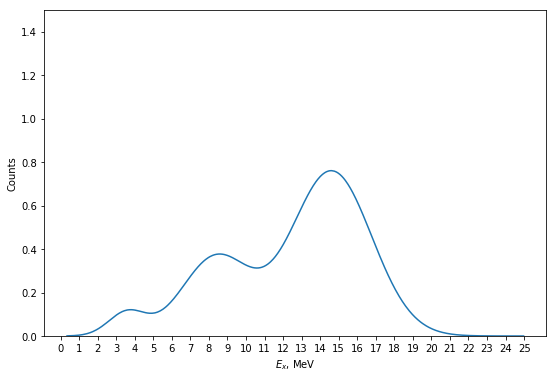

In [26]:
plt.figure(figsize=(9,6))
plt.plot(best_fit['Ex, MeV'].values, best_fit['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.ylim(0,1.5)
plt.xticks(np.arange(0,26,1))
plt.show()

In [27]:
#функция для отрезки резонансов выше энергии отрыва
def border_func(x_data, y_data, border):
    a=np.where(x_data<border)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))


def border_func2(x_data, y_data, border_l, border_r):
    a=np.where(x_data<border_r)
    b=np.where(x_data>border_l)
    temp_y = np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack((np.zeros((b[0][0])), temp_y[b]))

In [28]:
trapz(best_fit['y'].values, best_fit['Ex, MeV'].values)

6.057219427825755

(0, 20)

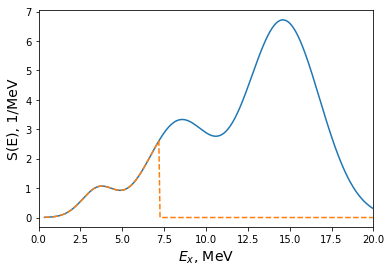

In [29]:
y = best_fit['y'].values / trapz(best_fit['y'].values, best_fit['Ex, MeV'].values) \
* total_GT

#y_best_fit_border = border_func(best_fit['x'].values, y_best_fit, S_n)
y_border = border_func(best_fit['Ex, MeV'].values, y, S_n)


plt.plot(best_fit['Ex, MeV'].values, y)
plt.plot(best_fit['Ex, MeV'].values, y_border, ls='--')
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)
#plt.savefig('S_E_func_76Ge.png', format='png', dpi=400)

In [30]:
total_GT

53.54

Сечение для непрерывной части

$\sigma = {(10^{-44}\ cm^2)} \times \int^{z-Q}_{0} {1.597 \cdot (\frac{g_a}{g_v})^2 \cdot \sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{GTR}(x) \cdot F(z-Q-x+0.511)} dx $ 


In [31]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data):
    e_energy = p - x + 0.511
    return 1.597*g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy\
    *np.interp(x,xp=x_data,fp=y_data)*num_tables_func(e_energy/0.511) 


In [32]:
#разбиваем интервал интегрирования на субинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [33]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

сечение без Sn

In [34]:
p_list = np.arange(0,20, 0.01) #p = z - Q

sigma_no_border_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['Ex, MeV'].values, y, 200) for p in p_list]

sigma_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

сечение с Sn

In [35]:
sigma_border_temp = [cross_sec(0,p, sigma_k_GTR, best_fit['Ex, MeV'].values, y_border, 200) for p in p_list]

sigma_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

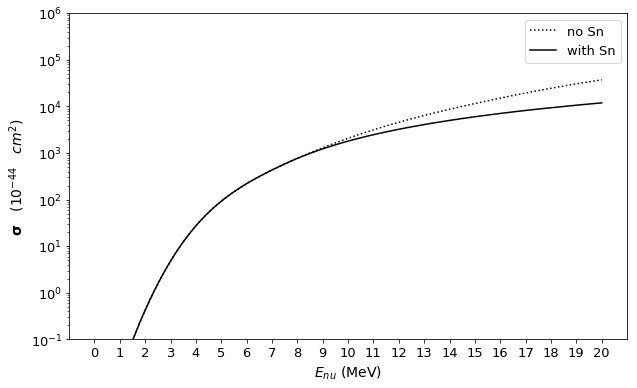

In [36]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_no_border_full, ls=':', c='black', 
         label='no Sn')
plt.plot(Energy_all_fluxes, sigma_border_full, ls='-', c='k', 
         label='with Sn')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(6))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

SNU с Sn

In [37]:
rate_calc(sigma_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.30822935728156703,
 'Total': 42.11398475672297,
 'b8': 41.43178422320444,
 'f17': 0.0017612308773412527,
 'hep': 0.1771487218685662,
 'n13': 0.0165790529772805,
 'name': 'test1',
 'o15': 0.06919678335842358,
 'pep': 0.10928538715535349,
 'pp': 0.0}

SNU без Sn

In [38]:
rate_calc(sigma_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.30822935728156703,
 'Total': 49.76482439905446,
 'b8': 48.972598109326036,
 'f17': 0.0017612308773412527,
 'hep': 0.28717447807845925,
 'n13': 0.0165790529772805,
 'name': 'test1',
 'o15': 0.06919678335842358,
 'pep': 0.10928538715535349,
 'pp': 0.0}

### данные из графика BGT

In [39]:
bgt_full = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_full.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
bgt_0_5 = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_0_5l.csv', 
                      sep=';', decimal=',', names=['x', 'y'])

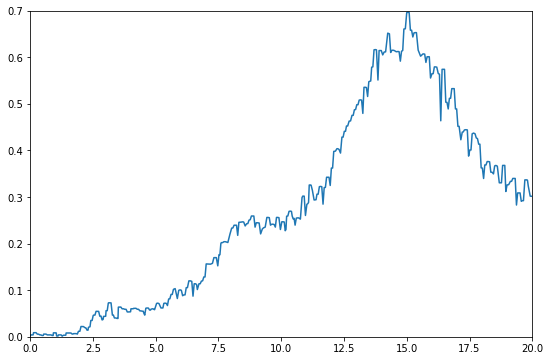

In [40]:
bgt = bgt_0_5.append(bgt_full[bgt_full['x']>5])

plt.figure(figsize=(9,6))
plt.plot(bgt['x'].values, bgt['y'].values)
plt.xlim(0,20)
plt.ylim(0,0.7)
plt.show()

In [41]:
trapz(bgt['y'].values, bgt['x'].values)

5.463277472256921

(0, 7)

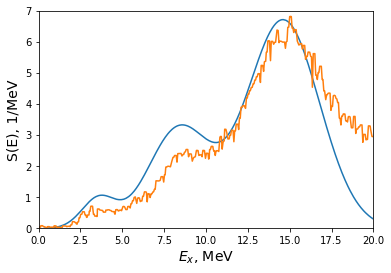

In [42]:
y_bgt = bgt['y'].values / trapz(bgt['y'].values, bgt['x'].values) \
* total_GT
y_bgt_border = border_func(bgt['x'].values, y_bgt, S_n)


plt.plot(best_fit['Ex, MeV'].values, y)
plt.plot(bgt['x'].values, y_bgt, )
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)
plt.ylim(0,7)
#plt.savefig('S_E_func_76Ge.png', format='png', dpi=400)


In [43]:
sigma_bgt_no_border_temp = [cross_sec(0,p, sigma_k_GTR, bgt['x'].values, y_bgt, 200) for p in p_list]

sigma_bgt_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_bgt_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [44]:
sigma_bgt_border_temp = [cross_sec(0,p, sigma_k_GTR, bgt['x'].values, y_bgt_border, 200) for p in p_list]

sigma_bgt_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_bgt_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

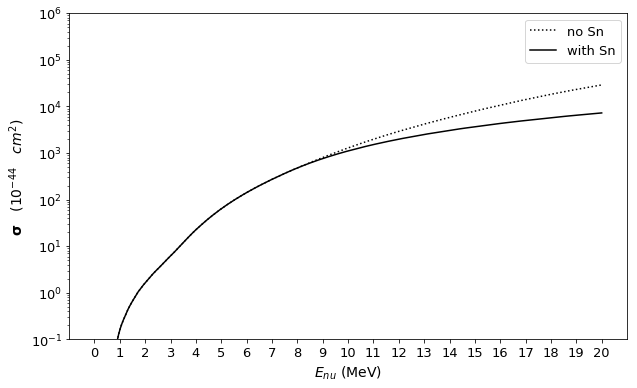

In [45]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_bgt_no_border_full, ls=':', c='black', 
         label='no Sn')
plt.plot(Energy_all_fluxes, sigma_bgt_border_full, ls='-', c='k', 
         label='with Sn')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(6))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

### BS05OP

In [46]:
rate_calc(sigma_bgt_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 2.9212454461204795,
 'Total': 30.293791523928103,
 'b8': 25.70602571411771,
 'f17': 0.013971570199011194,
 'hep': 0.10863860295563527,
 'n13': 0.1646452589248257,
 'name': 'test1',
 'o15': 0.5510984701356166,
 'pep': 0.8281664614748232,
 'pp': 0.0}

In [47]:
rate_calc(sigma_bgt_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 2.9212454461204795,
 'Total': 35.58909655543136,
 'b8': 30.917674604333477,
 'f17': 0.013971570199011194,
 'hep': 0.19229474424312676,
 'n13': 0.1646452589248257,
 'name': 'test1',
 'o15': 0.5510984701356166,
 'pep': 0.8281664614748232,
 'pp': 0.0}

### BP98

In [48]:
rate_calc(sigma_bgt_border_full, BP98_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_pep, func_Be_ampl=BP98_Be,)

{'Be': 2.897102921772376,
 'Total': 28.60089002298328,
 'b8': 23.26643803650373,
 'f17': 0.015143842356120011,
 'hep': 0.028769365221542754,
 'n13': 0.32446378387465646,
 'name': 'test1',
 'o15': 1.2583020863182317,
 'pep': 0.8106699869366227,
 'pp': 0.0}

In [49]:
rate_calc(sigma_bgt_no_border_full, BP98_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_pep, func_Be_ampl=BP98_Be,)

{'Be': 2.897102921772376,
 'Total': 33.34008961174459,
 'b8': 27.983484044344014,
 'f17': 0.015143842356120011,
 'hep': 0.050922946142568246,
 'n13': 0.32446378387465646,
 'name': 'test1',
 'o15': 1.2583020863182317,
 'pep': 0.8106699869366227,
 'pp': 0.0}

### BP98 OPAL92

In [50]:
rate_calc(sigma_bgt_border_full, BP98_OPAL92_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_OPAL92_pep, func_Be_ampl=BP98_OPAL92_Be,)

{'Be': 2.981601756990737,
 'Total': 30.053916489397146,
 'b8': 24.576586974481607,
 'f17': 0.015765864317034892,
 'hep': 0.028495371267051872,
 'n13': 0.3351898593746451,
 'name': 'test1',
 'o15': 1.3056066760294436,
 'pep': 0.8106699869366227,
 'pp': 0.0}

In [51]:
rate_calc(sigma_bgt_no_border_full, BP98_OPAL92_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=BP98_OPAL92_pep, func_Be_ampl=BP98_OPAL92_Be,)

{'Be': 2.981601756990737,
 'Total': 35.058525158134394,
 'b8': 29.5592530487828,
 'f17': 0.015765864317034892,
 'hep': 0.05043796570311522,
 'n13': 0.3351898593746451,
 'name': 'test1',
 'o15': 1.3056066760294436,
 'pep': 0.8106699869366227,
 'pp': 0.0}

### B16-GS98 (hight metallicity)

In [52]:
rate_calc(sigma_bgt_border_full, B16_GS98_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=B16_GS98_pep, func_Be_ampl=B16_GS98_Be,)

{'Be': 2.975566125903711,
 'Total': 29.238282813733914,
 'b8': 24.666942073652493,
 'f17': 0.012655754512460482,
 'hep': 0.10932358784186247,
 'n13': 0.14909244944984215,
 'name': 'test1',
 'o15': 0.4848720445399201,
 'pep': 0.8398307778336236,
 'pp': 0.0}

###  B16-AGSS09met (low metallicity)

In [53]:
rate_calc(sigma_bgt_border_full, B16_AGSS09met_flux, Energy_all_fluxes, step_all_fluxes, 
          func_pep_ampl=B16_AGSS09met_pep, func_Be_ampl=B16_AGSS09met_Be,)

{'Be': 2.7160339891616028,
 'Total': 24.468247117484992,
 'b8': 20.32989731344986,
 'f17': 0.0077991984330096735,
 'hep': 0.11302250622748942,
 'n13': 0.10940597009988418,
 'name': 'test1',
 'o15': 0.3405930459207244,
 'pep': 0.851495094192424,
 'pp': 0.0}

In [54]:
no11 = rate_calc(sigma_bgt_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='BS05OP with neutron separation')

no22 = rate_calc(sigma_bgt_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='BS05OP without neutron separation')

no33 = rate_calc(sigma_bgt_border_full, B16_GS98_flux, Energy_all_fluxes, 
                step_all_fluxes, name='B16-GS98 (hight metallicity) with neutron separation')

no44 = rate_calc(sigma_bgt_border_full, B16_AGSS09met_flux, Energy_all_fluxes, 
                step_all_fluxes, name='B16-AGSS09met (low metallicity) with neutron separation')



In [55]:
output_table0 = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])

for elem in [no11, no22, no33, no44] : 
    output_table0 = output_table0.append(elem, ignore_index=True)
    
for elem in ['Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 'pp',  'Total']:
    output_table0[elem] = output_table0[elem].round(3)
output_table0

,name,Be,f17,b8,n13,pep,o15,hep,pp,Total
0,BS05OP with neutron separation,2.921,0.014,25.706,0.165,0.828,0.551,0.109,0.0,30.294
1,BS05OP without neutron separation,2.921,0.014,30.918,0.165,0.828,0.551,0.192,0.0,35.589
2,B16-GS98 (hight metallicity) with neutron sepa...,2.921,0.013,24.667,0.149,0.828,0.485,0.109,0.0,29.172
3,B16-AGSS09met (low metallicity) with neutron s...,2.921,0.008,20.330,0.109,0.828,0.341,0.113,0.0,24.650


In [56]:
#output_table0.to_excel('models_comparison.xls')

## Матричные элементы от ЮС

In [61]:
En = np.array([0.2, 0.54, 1.58, 1.97, 2.76, 3.08, 3.45, 6.0, 8.34, 14.8, 20.59, 20.94, \
               21.09, 21.22, 29.70])

Mn = np.array([0.0025, 0.0025, 0.01, 0.01, 0.02, 0.10, 0.01, 0.2, 1.2, 30.8, 0.5, 0.8, \
               0.5, 1.03, 6.3])

np.sum(Mn)

41.485

In [62]:
for i in Mn: print(i)

0.0025
0.0025
0.01
0.01
0.02
0.1
0.01
0.2
1.2
30.8
0.5
0.8
0.5
1.03
6.3


In [63]:
def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

Ex = np.arange(0,40,0.01)
w = En
M_square = Mn
alpha = 0.018


norm_factors = []
for w_i,M_i in zip(w, M_square):
    y_values = breit_vigner3(Ex, 1, w_i, alpha*w_i**2)
    norm_factors.append(trapz(y_values, Ex))

In [64]:
plots = np.zeros((w.shape[0], Ex.shape[0]))
for idx, w_i, M_i, norm_i in zip(range(w.shape[0]), w, M_square, norm_factors):
    amplitude = M_i / norm_i
    y_values = breit_vigner3(Ex, amplitude, w_i, alpha*w_i**2)
    plots[idx] = y_values
    
summ = np.sum(plots, axis=0)

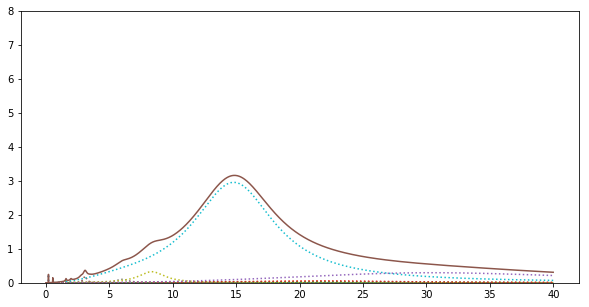

In [65]:
plt.figure(figsize=(10,5))
plt.ylim(0,8)
for elem in plots:
    plt.plot(Ex, elem, ls=':')
plt.plot(Ex, summ)
plt.show()

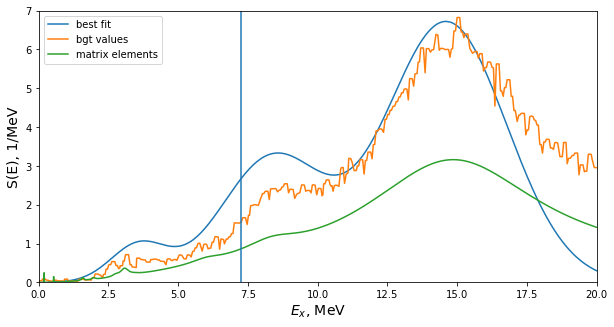

In [66]:
plt.figure(figsize=(10,5))
plt.plot(best_fit['Ex, MeV'].values, y, label='best fit')
plt.plot(bgt['x'].values, y_bgt, label='bgt values')
plt.plot(Ex, summ, label='matrix elements')
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.axvline(S_n)
plt.xlim(0,20)
plt.ylim(0,7)
plt.legend()
plt.show()

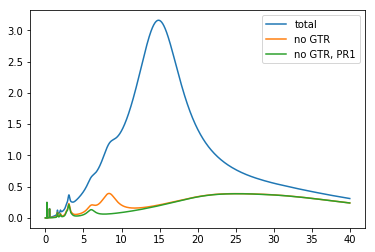

In [67]:
summ_border = border_func(Ex, summ, S_n)
summ_noGTR = summ - plots[9]
summ_noGTR_border = border_func(Ex, summ_noGTR, S_n)
summ_noGTR_PR1 = summ_noGTR - plots[8]
summ_noGTR_PR1_border = border_func(Ex, summ_noGTR_PR1, S_n)

plt.plot(Ex, summ, label='total')
plt.plot(Ex, summ_noGTR, label='no GTR')
plt.plot(Ex, summ_noGTR_PR1, label='no GTR, PR1')
plt.legend()
plt.show()

### total

In [68]:
sigma_matr_no_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ, 200) for p in p_list]

sigma_matr_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_matr_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

sigma_matr_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_border, 200) for p in p_list]

sigma_matr_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, fp=sigma_matr_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

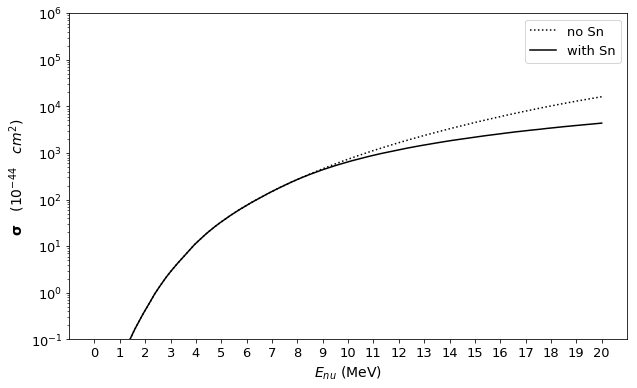

In [69]:
plt.figure(figsize=(10,6))
#plt.plot(Energy_all_fluxes, sigma_best_fit_full, ls=':', c='r', label='cross-section with only best_fit_full')
#plt.plot(Energy_all_fluxes, sigma_best_fit_Sn, ls=':', c='orange', label='cross-section with only best_fit_Sn')
plt.plot(Energy_all_fluxes, sigma_matr_no_border_full, ls=':', c='black', 
         label='no Sn')
plt.plot(Energy_all_fluxes, sigma_matr_border_full, ls='-', c='k', 
         label='with Sn')
plt.xlabel('$E_{nu}$ (MeV)', fontsize=14)
plt.ylabel('$\mathbf{\sigma} \quad ( 10^{-44} \quad cm^2)$', fontsize=14)

plt.yscale('log')
plt.legend(fontsize=13)
#plt.grid(True, which="both",ls="-", color='0.8')
plt.ylim(10**(-1), 10**(6))
plt.xticks(np.arange(0,21))
plt.tick_params(labelsize=13)
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_section_best_fit_5_Sn_norm19.png', format='png', dpi=500)

In [70]:
### BS05OP
rate_calc(sigma_matr_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.27580424830926087,
 'Total': 15.441026510393897,
 'b8': 14.822680839805377,
 'f17': 0.00246520250410724,
 'hep': 0.06425636604026722,
 'n13': 0.02063288868384103,
 'name': 'test1',
 'o15': 0.09699327228537127,
 'pep': 0.15819369276567413,
 'pp': 0.0}

In [71]:
rate_calc(sigma_matr_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.27580424830926087,
 'Total': 18.20814693800982,
 'b8': 17.54464161976183,
 'f17': 0.00246520250410724,
 'hep': 0.1094160136997335,
 'n13': 0.02063288868384103,
 'name': 'test1',
 'o15': 0.09699327228537127,
 'pep': 0.15819369276567413,
 'pp': 0.0}

### no GTR

In [72]:
sigma_matr_noGTR_no_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR, 200) for p in p_list]

sigma_matr_noGTR_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                      fp=sigma_matr_noGTR_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

sigma_matr_noGTR_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR_border, 200) for p in p_list]

sigma_matr_noGTR_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                         fp=sigma_matr_noGTR_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [73]:
### BS05OP
rate_calc(sigma_matr_noGTR_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.2672799092727694,
 'Total': 5.5976171172725175,
 'b8': 5.074507145838451,
 'f17': 0.0020851467170695994,
 'hep': 0.02074978564906726,
 'n13': 0.019415305278160832,
 'name': 'test1',
 'o15': 0.08215484631369621,
 'pep': 0.13142497820330282,
 'pp': 0.0}

In [74]:
rate_calc(sigma_matr_noGTR_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.2672799092727694,
 'Total': 6.363801324454244,
 'b8': 5.831070950925827,
 'f17': 0.0020851467170695994,
 'hep': 0.030370187743417973,
 'n13': 0.019415305278160832,
 'name': 'test1',
 'o15': 0.08215484631369621,
 'pep': 0.13142497820330282,
 'pp': 0.0}

### no GTR no PR1

In [75]:
sigma_matr_noGTR_noPR1_no_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR_PR1, 200) for p in p_list]

sigma_matr_noGTR_noPR1_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                      fp=sigma_matr_noGTR_noPR1_no_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

sigma_matr_noGTR_noPR1_border_temp = [cross_sec(0,p, sigma_k_GTR, Ex, summ_noGTR_PR1_border, 200) for p in p_list]

sigma_matr_noGTR_noPR1_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                   fp=sigma_matr_noGTR_noPR1_border_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

In [76]:
### BS05OP
rate_calc(sigma_matr_noGTR_noPR1_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.2641365303645267,
 'Total': 4.052430650518406,
 'b8': 3.5548227597409485,
 'f17': 0.0019504292258294962,
 'hep': 0.013763607657538486,
 'n13': 0.018968717042210776,
 'name': 'test1',
 'o15': 0.07689214717545031,
 'pep': 0.12189645931190078,
 'pp': 0.0}

In [77]:
rate_calc(sigma_matr_noGTR_noPR1_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.2641365303645267,
 'Total': 4.218231624767188,
 'b8': 3.7179382521449775,
 'f17': 0.0019504292258294962,
 'hep': 0.016449089502291726,
 'n13': 0.018968717042210776,
 'name': 'test1',
 'o15': 0.07689214717545031,
 'pep': 0.12189645931190078,
 'pp': 0.0}

### to Lutostansky

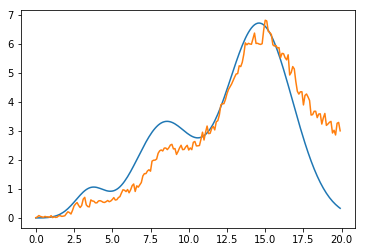

In [78]:
Ex2 = np.arange(0,20,0.1)

exp_power_func = np.interp(Ex2, best_fit['Ex, MeV'].values, y)
bgt_digit = np.interp(Ex2, bgt['x'].values, y_bgt)

plt.plot(Ex2, exp_power_func)
plt.plot(Ex2, bgt_digit)
plt.show()

In [79]:
output = pd.DataFrame(data={'Ex, MeV':Ex2,})
output['Experimetal_spec'] = exp_power_func
output['BGT_graph'] = bgt_digit
#output.to_excel('127Xe_data.xls', index=False)

In [80]:
output.head()

,"Ex, MeV",Experimetal_spec,BGT_graph
0,0.0,0.005331,0.013527
1,0.1,0.005331,0.040147
2,0.2,0.005331,0.086733
3,0.3,0.005331,0.056785
4,0.4,0.006276,0.040192


In [81]:
output.to_excel('127Xe_data.xls', index=False)

In [82]:
Et_53=[5,6,7,8,9,10,12,14,16,18,20,22,24,26,28,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,
110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,
340,350,360,370,380,390,400,450,500,550,600,650,700,750,800,850,900,950,1000,1100,1200,1300,
1400,1500,1600,1700,1800,1900,2000,2200,2400,2600,2800,3000,3200,3400,3600,3800,4000,4500,
5000,5500,6000,7000,8000,9000,10000]

In [83]:
#for i in range(100):
#    Et_53[i]=0.511+Et_53[i]/1000
Ft_53=[43.66,39.89,36.97,34.61,32.67,31.02,28.37,26.31,24.66,23.29,22.18,21.14,20.27,19.51,
18.83,18.22,16.94,15.91,15.06,14.35,13.75,13.22,12.76,12.35,11.99,11.66,11.37,11.10,10.85,
10.62,10.22,9.879,9.577,9.310,9.074,8.862,8.671,8.498,8.340,8.196,8.063,7.940,7.827,7.721,
7.622,7.530,7.443,7.362,7.385,7.212,7.144,7.079,7.017,6.958,6.902,6.848,6.797,6.748,6.701,
6.656,6.456,6.289,6.147,6.024,5.916,5.820,5.734,5.656,5.584,5.518,5.457,5.400,5.296,5.203,
5.119,5.043,4.973,4.908,4.848,4.791,4.733,4.687,4.594,4.508,4.428,4.354,4.284,4.218,4.156,
4.096,4.040,3.985,3.858,3.741,3.633,3.532,3.346,3.191,3.054,2.926]

In [84]:
#Ft_53mod=[0 for i in range(102)]
#for i in range(100):
#    Ft_53mod[i+1]=Ft_53[i]*(Et_53[i])*((Et_53[i])2-0.511**2)(0.5)
#Ft_53mod[0]=(Ft_53mod[1]-Ft_53mod[2])*5+Ft_53mod[1]
#Ft_53mod[101]=Ft_53mod[100]-(Ft_53mod[99]-Ft_53mod[100])*10

In [85]:
#Et_53mod=[0,5,6,7,8,9,10,12,14,16,18,20,22,24,26,28,30,35,40,45,50,55,60,65,70,75,80,85,90,95,
#100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,
#330,340,350,360,370,380,390,400,450,500,550,600,650,700,750,800,850,900,950,1000,1100,1200,
#1300,1400,1500,1600,1700,1800,1900,2000,2200,2400,2600,2800,3000,3200,3400,3600,3800,4000,
#4500,5000,5500,6000,7000,8000,9000,10000,20000]

In [86]:
#for i in range(102):
#    Et_53mod[i]=0.511+Et_53mod[i]/1000
#def F_53(E):
#    return numpy.interp(E, Et_53, Ft_53)
#def F_53mod(E):
#    return numpy.interp(E, Et_53mod, Ft_53mod)

In [87]:
def Suslov_func(e_e):
    #input энергия электрона в кэв
    f = interp1d(x=Et_53, y=Ft_53, kind='linear', fill_value='extrapolate')
#    return np.interp(x = e_e, xp = Et_53, 
#                     fp = Ft_53)
    return f(e_e)

def Pi_e_func2(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    return np.sqrt(e_e**2 - 1)

def Janecki_func(e_e):
    #input энергия электрона в кэв
    E = 1 + e_e/511 # полная энергия электрона в единицах mc^2
    p = Pi_e_func2(E)
    return np.interp(x = p, xp = Fermi_func_new_data['p'], 
                     fp = Fermi_func_new_data['F0L0'])

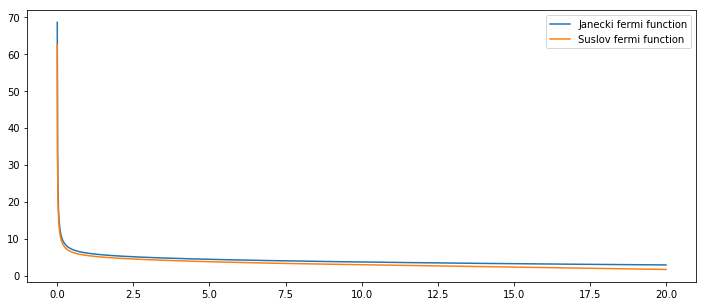

In [88]:
e_e = np.linspace(0,20, 2000) #MeV

plt.figure(figsize=(12,5))
plt.plot(e_e, Janecki_func(e_e*1000), label='Janecki fermi function')
plt.plot(e_e, Suslov_func(e_e*1000), label='Suslov fermi function')
plt.legend()
plt.show()

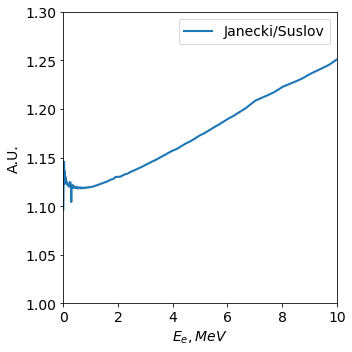

In [89]:
plt.figure(figsize=(5,5))
plt.plot(e_e, Janecki_func(e_e*1000)/ Suslov_func(e_e*1000), label='Janecki/Suslov', linewidth=2.1)
plt.legend(fontsize=14)
#plt.xlim(0,1)
plt.ylim(1,1.3)
plt.xlim(0,10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$E_e, MeV$", fontsize=14)
plt.ylabel("A.U.", fontsize=14)
plt.tight_layout()
plt.savefig('fermi_func_comparison.png', format='png', dpi=500)
plt.show()

### расчет c декомпозицией

In [90]:
decomp = pd.read_excel('127Xe_bgt_decomp.xls')
decomp.head(20)

,"Ex, MeV",best_fit,bgt,gtr,pr1,pr2
0,0.00,0.00000,0.014032,0.00000,0.00000,0.00000
1,0.05,0.00018,0.041647,0.00007,0.00004,0.00007
2,0.10,0.00071,0.041647,0.00027,0.00014,0.00030
3,0.15,0.00162,0.089973,0.00061,0.00032,0.00069
4,0.20,0.00288,0.089973,0.00108,0.00057,0.00123
5,0.25,0.00451,0.083343,0.00170,0.00089,0.00192
6,0.30,0.00647,0.058906,0.00246,0.00127,0.00274
7,0.35,0.00877,0.054557,0.00337,0.00171,0.00369
8,0.40,0.01135,0.041694,0.00442,0.00220,0.00473
9,0.45,0.01421,0.035951,0.00563,0.00273,0.00585


In [91]:
trapz(decomp['bgt'].values, decomp['Ex, MeV'].values),\
trapz(decomp['best_fit'].values, decomp['Ex, MeV'].values),\
trapz(decomp['gtr'].values, decomp['Ex, MeV'].values), \
trapz(decomp['pr1'].values, decomp['Ex, MeV'].values), \
trapz(decomp['pr2'].values, decomp['Ex, MeV'].values), \

(55.58062392490359, 55.568871, 52.711257, 2.4391040000000004, 0.41851)

In [92]:
y_total_border = border_func(decomp['Ex, MeV'].values, decomp['best_fit'].values, S_n)
y_bgt_border = border_func(decomp['Ex, MeV'].values, decomp['bgt'].values, S_n)
y_gtr_border = border_func(decomp['Ex, MeV'].values, decomp['gtr'].values, S_n)
y_pr1_border = border_func(decomp['Ex, MeV'].values, decomp['pr1'].values, S_n)
y_pr2_border = border_func(decomp['Ex, MeV'].values, decomp['pr2'].values, S_n)

### bgt

In [93]:
sigma_y_bgt_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['bgt'].values, 200) for p in p_list]
sigma_y_bgt_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_y_bgt_no_border_temp)

sigma_y_bgt_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_bgt_border, 200) for p in p_list]
sigma_y_bgt_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_y_bgt_border_temp)

In [94]:
### BS05OP
rate_calc(sigma_y_bgt_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 3.028753207265253,
 'Total': 31.355310935660786,
 'b8': 26.592277445253995,
 'f17': 0.014540688379330318,
 'hep': 0.1124154985716051,
 'n13': 0.17030037295824904,
 'name': 'test1',
 'o15': 0.573539491249559,
 'pep': 0.8634842319827951,
 'pp': 0.0}

In [95]:
rate_calc(sigma_y_bgt_no_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 3.028753207265253,
 'Total': 36.85019849608561,
 'b8': 32.00037149177886,
 'f17': 0.014540688379330318,
 'hep': 0.19920901247156164,
 'n13': 0.17030037295824904,
 'name': 'test1',
 'o15': 0.573539491249559,
 'pep': 0.8634842319827951,
 'pp': 0.0}

### y_total

In [96]:
sigma_y_tot_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['best_fit'].values, 200) for p in p_list]
sigma_y_tot_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_y_tot_no_border_temp)

sigma_y_tot_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_total_border, 200) for p in p_list]
sigma_y_tot_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_y_tot_border_temp)

In [97]:
### BS05OP
rate_calc(sigma_y_tot_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.049343010270475815,
 'Total': 27.631640033387253,
 'b8': 27.245694372056526,
 'f17': 0.0019347048485756832,
 'hep': 0.11545294980452966,
 'n13': 0.006780134263135427,
 'name': 'test1',
 'o15': 0.07561943300795258,
 'pep': 0.13681542913605554,
 'pp': 0.0}

In [98]:
rate_calc(sigma_y_tot_no_border_full, \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.049343010270475815,
 'Total': 33.06199970948043,
 'b8': 32.58928755896896,
 'f17': 0.0019347048485756832,
 'hep': 0.20221943898527522,
 'n13': 0.006780134263135427,
 'name': 'test1',
 'o15': 0.07561943300795258,
 'pep': 0.13681542913605554,
 'pp': 0.0}

### gtr

In [99]:
sigma_gtr_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['gtr'].values, 200) for p in p_list]
sigma_gtr_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_gtr_no_border_temp)

sigma_gtr_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_gtr_border, 200) for p in p_list]
sigma_gtr_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_gtr_border_temp)

In [100]:
### BS05OP
rate_calc((sigma_y_tot_border_full-sigma_gtr_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.03071350936310167,
 'Total': 7.871145346608545,
 'b8': 7.681367014374966,
 'f17': 0.0011356979056920682,
 'hep': 0.02874950158294634,
 'n13': 0.004192076154933009,
 'name': 'test1',
 'o15': 0.04442248812010721,
 'pep': 0.08056505910679923,
 'pp': 0.0}

In [101]:
rate_calc((sigma_y_tot_no_border_full-sigma_gtr_no_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.03071350936310167,
 'Total': 9.381482075403774,
 'b8': 9.174630348717708,
 'f17': 0.0011356979056920682,
 'hep': 0.04582289603543354,
 'n13': 0.004192076154933009,
 'name': 'test1',
 'o15': 0.04442248812010721,
 'pep': 0.08056505910679923,
 'pp': 0.0}

### pr1

In [102]:
sigma_pr1_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['pr1'].values, 200) for p in p_list]
sigma_pr1_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_pr1_no_border_temp)

sigma_pr1_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_pr1_border, 200) for p in p_list]
sigma_pr1_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_pr1_border_temp)

In [103]:
### BS05OP
rate_calc((sigma_y_tot_border_full-sigma_gtr_border_full-sigma_pr1_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.020890776953677026,
 'Total': 5.495264334731887,
 'b8': 5.368032350692211,
 'f17': 0.0007688783040341784,
 'hep': 0.01808277041925757,
 'n13': 0.0028594294062403215,
 'name': 'test1',
 'o15': 0.030077692012741315,
 'pep': 0.054552436943725836,
 'pp': 0.0}

In [104]:
rate_calc((sigma_y_tot_no_border_full-sigma_gtr_no_border_full-sigma_pr1_no_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': 0.020890776953677026,
 'Total': 5.502744432259089,
 'b8': 5.37542741348504,
 'f17': 0.0007688783040341784,
 'hep': 0.01816780515363028,
 'n13': 0.0028594294062403215,
 'name': 'test1',
 'o15': 0.030077692012741315,
 'pep': 0.054552436943725836,
 'pp': 0.0}

### pr2

In [105]:
sigma_pr2_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                      decomp['pr2'].values, 200) for p in p_list]
sigma_pr2_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                     fp=sigma_pr2_no_border_temp)

sigma_pr2_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp['Ex, MeV'].values, 
                                   y_pr2_border, 200) for p in p_list]
sigma_pr2_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_pr2_border_temp)

In [106]:
rate_calc((sigma_y_tot_border_full-sigma_gtr_border_full-sigma_pr1_border_full-sigma_pr2_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,)

{'Be': -1.1767605119505919e-17,
 'Total': -9.32559633417526e-17,
 'b8': -6.837426245418373e-17,
 'f17': -8.017027414109984e-20,
 'hep': 1.6649239799065823e-19,
 'n13': -1.2798017381926387e-19,
 'name': 'test1',
 'o15': -3.219208374544984e-18,
 'pep': -9.853229343548264e-18,
 'pp': 0.0}

In [107]:
rate_calc((sigma_y_tot_border_full-sigma_gtr_border_full-sigma_pr1_border_full-sigma_pr2_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes,).keys()

dict_keys(['f17', 'pp', 'b8', 'pep', 'o15', 'Be', 'hep', 'n13', 'Total', 'name'])

In [108]:
output_table = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])

In [109]:
no1 = rate_calc(sigma_y_bgt_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt)')

no2 = rate_calc(sigma_y_tot_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (best_fit)')
no3 = rate_calc(sigma_matr_no_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,
               name='R-total (theory)')

no4 = rate_calc((sigma_y_tot_no_border_full-sigma_gtr_no_border_full), BS05OP_flux, 
                Energy_all_fluxes, step_all_fluxes,name='R-total (best_fit) - GTR')
no5 = rate_calc(sigma_matr_noGTR_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (theory) - GTR')

no6 = rate_calc((sigma_y_tot_no_border_full-sigma_gtr_no_border_full-sigma_pr1_no_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes, name='R-total (best_fit) - GTR - PR1')
no7 = rate_calc(sigma_matr_noGTR_noPR1_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (theory) - GTR - PR1')

In [110]:
output_table = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])

for elem in [no1, no2, no3, no4, no5, no6, no7] : 
    output_table = output_table.append(elem, ignore_index=True)
    
for elem in ['Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 'pp',  'Total']:
    output_table[elem] = output_table[elem].round(3)
output_table

,name,Be,f17,b8,n13,pep,o15,hep,pp,Total
0,R-total (график bgt),3.029,0.015,32.000,0.170,0.863,0.574,0.199,0.0,36.850
1,R-total (best_fit),0.049,0.002,32.589,0.007,0.137,0.076,0.202,0.0,33.062
2,R-total (theory),0.276,0.002,17.545,0.021,0.158,0.097,0.109,0.0,18.208
3,R-total (best_fit) - GTR,0.031,0.001,9.175,0.004,0.081,0.044,0.046,0.0,9.381
4,R-total (theory) - GTR,0.267,0.002,5.831,0.019,0.131,0.082,0.030,0.0,6.364
5,R-total (best_fit) - GTR - PR1,0.021,0.001,5.375,0.003,0.055,0.030,0.018,0.0,5.503
6,R-total (theory) - GTR - PR1,0.264,0.002,3.718,0.019,0.122,0.077,0.016,0.0,4.218


In [111]:
#output_table.to_excel('no_border_comparison.xls')

In [112]:
no11 = rate_calc(sigma_y_bgt_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt)')

no22 = rate_calc(sigma_y_tot_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (best_fit)')
no33 = rate_calc(sigma_matr_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,
               name='R-total (theory)')

no44 = rate_calc((sigma_y_tot_border_full-sigma_gtr_border_full), BS05OP_flux, 
                Energy_all_fluxes, step_all_fluxes,name='R-total (best_fit) - GTR')
no55 = rate_calc(sigma_matr_noGTR_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (theory) - GTR')

no66 = rate_calc((sigma_y_tot_border_full-sigma_gtr_border_full-sigma_pr1_border_full), \
          BS05OP_flux, Energy_all_fluxes, step_all_fluxes, name='R-total (best_fit) - GTR - PR1')
no77 = rate_calc(sigma_matr_noGTR_noPR1_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (theory) - GTR - PR1')

In [113]:
output_table0 = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])

for elem in [no11, no22, no33, no44, no55, no66, no77] : 
    output_table0 = output_table0.append(elem, ignore_index=True)
    
for elem in ['Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 'pp',  'Total']:
    output_table0[elem] = output_table0[elem].round(3)
output_table0

,name,Be,f17,b8,n13,pep,o15,hep,pp,Total
0,R-total (график bgt),3.029,0.015,26.592,0.170,0.863,0.574,0.112,0.0,31.355
1,R-total (best_fit),0.049,0.002,27.246,0.007,0.137,0.076,0.115,0.0,27.632
2,R-total (theory),0.276,0.002,14.823,0.021,0.158,0.097,0.064,0.0,15.441
3,R-total (best_fit) - GTR,0.031,0.001,7.681,0.004,0.081,0.044,0.029,0.0,7.871
4,R-total (theory) - GTR,0.267,0.002,5.075,0.019,0.131,0.082,0.021,0.0,5.598
5,R-total (best_fit) - GTR - PR1,0.021,0.001,5.368,0.003,0.055,0.030,0.018,0.0,5.495
6,R-total (theory) - GTR - PR1,0.264,0.002,3.555,0.019,0.122,0.077,0.014,0.0,4.052


In [114]:
#output_table0.to_excel('border_comparison.xls')

## check models with different $\alpha$ and $\beta$

In [128]:
decomp2 = pd.read_excel('127Xe_decomp_find_coeff.xls')
decomp2.head()

,"Ex, MeV",GTR (alpha E^2),PR1 (alpha E^2),PR2 (alpha E^2),alpha E^2,alpha E^2+beta E^3,alpha E^2-beta E^3,bgt
0,0.00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.014032
1,0.05,0.00007,0.00003,0.00016,0.00026,0.00028,0.00026,0.041647
2,0.10,0.00027,0.00013,0.00056,0.00096,0.00102,0.00097,0.041647
3,0.15,0.00060,0.00030,0.00105,0.00195,0.00198,0.00200,0.089973
4,0.20,0.00108,0.00053,0.00148,0.00309,0.00300,0.00319,0.089973


In [116]:
trapz(decomp2['bgt'].values, decomp2['Ex, MeV'].values),\
trapz(decomp2['alpha E^2'].values, decomp2['Ex, MeV'].values),\
trapz(decomp2['alpha E^2+beta E^3'].values, decomp2['Ex, MeV'].values), \
trapz(decomp2['alpha E^2-beta E^3'].values, decomp2['Ex, MeV'].values), \

(55.58062392490359, 55.610859999999995, 55.47721875, 55.54809675)

In [119]:
y_bgt_border = border_func(decomp2['Ex, MeV'].values, decomp2['bgt'].values, S_n)
y_alph_border = border_func(decomp2['Ex, MeV'].values, decomp2['alpha E^2'].values, S_n)
y_alph_plus_b_border = border_func(decomp2['Ex, MeV'].values, decomp2['alpha E^2+beta E^3'].values, S_n)
y_alph_min_b_border = border_func(decomp2['Ex, MeV'].values, decomp2['alpha E^2-beta E^3'].values, S_n)

In [129]:
y_GTR_border = border_func(decomp2['Ex, MeV'].values, decomp2['GTR (alpha E^2)'].values, S_n)
y_PR1_border = border_func(decomp2['Ex, MeV'].values, decomp2['PR1 (alpha E^2)'].values, S_n)
y_PR2_border = border_func(decomp2['Ex, MeV'].values, decomp2['PR2 (alpha E^2)'].values, S_n)

In [121]:
sigma_bgt_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp2['Ex, MeV'].values, 
                                   y_bgt_border, 200) for p in p_list]
sigma_bgt_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_bgt_border_temp)

sigma_alph_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp2['Ex, MeV'].values, 
                                   y_alph_border, 200) for p in p_list]
sigma_alph_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_alph_border_temp)

In [122]:
sigma_alph_plus_b_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp2['Ex, MeV'].values, 
                                   y_alph_plus_b_border, 200) for p in p_list]
sigma_alph_plus_b_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_alph_plus_b_border_temp)

sigma_alph_min_b_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp2['Ex, MeV'].values, 
                                   y_alph_min_b_border, 200) for p in p_list]
sigma_alph_min_b_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_alph_min_b_border_temp)

In [125]:
no11 = rate_calc(sigma_bgt_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt)')

no22 = rate_calc(sigma_alph_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (alpha E^2)')
no33 = rate_calc(sigma_alph_plus_b_border_full, BS05OP_flux, Energy_all_fluxes, step_all_fluxes,
               name='R-total (alpha E^2+beta E^3)')
no44 = rate_calc((sigma_alph_min_b_border_full), BS05OP_flux, 
                Energy_all_fluxes, step_all_fluxes,name='R-total (alpha E^2-beta E^3)')


In [126]:
output_table0 = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])

for elem in [no11, no22, no33, no44] : 
    output_table0 = output_table0.append(elem, ignore_index=True)
    
for elem in ['Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 'pp',  'Total']:
    output_table0[elem] = output_table0[elem].round(3)
output_table0

,name,Be,f17,b8,n13,pep,o15,hep,pp,Total
0,R-total (график bgt),3.029,0.015,26.592,0.170,0.863,0.574,0.112,0.0,31.355
1,R-total (alpha E^2),0.060,0.002,26.841,0.006,0.106,0.060,0.116,0.0,27.190
2,R-total (alpha E^2+beta E^3),0.061,0.001,26.375,0.006,0.103,0.058,0.114,0.0,26.718
3,R-total (alpha E^2-beta E^3),0.061,0.002,27.218,0.007,0.109,0.061,0.117,0.0,27.575


In [127]:
output_table0.to_excel('127Xe_result_find_coeff_Janeki.xls')

In [130]:
sigma_GTR_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp2['Ex, MeV'].values, 
                                   y_GTR_border, 200) for p in p_list]
sigma_GTR_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_GTR_border_temp)

sigma_PR1_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp2['Ex, MeV'].values, 
                                   y_PR1_border, 200) for p in p_list]
sigma_PR1_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_PR1_border_temp)

sigma_PR2_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp2['Ex, MeV'].values, 
                                   y_PR2_border, 200) for p in p_list]
sigma_PR2_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_PR2_border_temp)

In [133]:
no55 = rate_calc(sigma_bgt_border_full-sigma_GTR_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt) - GTR')

no66 = rate_calc(sigma_bgt_border_full-sigma_GTR_border_full-sigma_PR1_border_full, 
                 BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt) - GTR - PR1')
no77 = rate_calc(sigma_bgt_border_full-sigma_GTR_border_full-sigma_PR1_border_full-sigma_PR2_border_full, 
                 BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt) - GTR - PR1 - PR2')
#no44 = rate_calc((sigma_alph_min_b_border_full), BS05OP_flux, 
#                Energy_all_fluxes, step_all_fluxes,name='R-total (alpha E^2-beta E^3)')

In [134]:
output_table1 = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])

for elem in [no55, no66, no77] : 
    output_table1 = output_table1.append(elem, ignore_index=True)
    
for elem in ['Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 'pp',  'Total']:
    output_table1[elem] = output_table1[elem].round(3)
output_table1

,name,Be,f17,b8,n13,pep,o15,hep,pp,Total
0,R-total (график bgt) - GTR,3.010,0.014,7.274,0.168,0.807,0.542,0.027,0.0,11.843
1,R-total (график bgt) - GTR - PR1,3.001,0.013,3.611,0.166,0.781,0.528,0.010,0.0,8.111
2,R-total (график bgt) - GTR - PR1 - PR2,2.969,0.013,-0.249,0.164,0.757,0.514,-0.003,0.0,4.165


In [136]:
output_table1.to_excel('127Xe_result_find_coeff_Janeki-GTR-PR.xls')

In [138]:
sigma_bgt_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp2['Ex, MeV'].values, 
                                   decomp2['bgt'].values, 200) for p in p_list]
sigma_bgt_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_bgt_no_border_temp)

sigma_GTR_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp2['Ex, MeV'].values, 
                                   decomp2['GTR (alpha E^2)'].values, 200) for p in p_list]
sigma_GTR_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_GTR_no_border_temp)

sigma_PR1_no_border_temp = [cross_sec(0,p, sigma_k_GTR, decomp2['Ex, MeV'].values, 
                                   decomp2['PR1 (alpha E^2)'].values, 200) for p in p_list]
sigma_PR1_no_border_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_PR1_no_border_temp)


In [139]:
no88 = rate_calc(sigma_bgt_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt)')

no99 = rate_calc(sigma_bgt_no_border_full-sigma_GTR_no_border_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt) - GTR')

no1010 = rate_calc(sigma_bgt_no_border_full-sigma_GTR_no_border_full-sigma_PR1_no_border_full, 
                 BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt) - GTR - PR1')

In [140]:
output_table2 = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])

for elem in [no88, no99, no1010] : 
    output_table2 = output_table2.append(elem, ignore_index=True)
    
for elem in ['Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 'pp',  'Total']:
    output_table2[elem] = output_table2[elem].round(3)
output_table2

,name,Be,f17,b8,n13,pep,o15,hep,pp,Total
0,R-total (график bgt),3.029,0.015,32.000,0.170,0.863,0.574,0.199,0.0,36.850
1,R-total (график bgt) - GTR,3.010,0.014,8.909,0.168,0.807,0.542,0.045,0.0,13.496
2,R-total (график bgt) - GTR - PR1,3.001,0.013,3.640,0.166,0.781,0.528,0.010,0.0,8.140


In [141]:
output_table2.to_excel('127Xe_result_find_coeff_Janeki_no_border-GTR-PR.xls')

(0, 7)

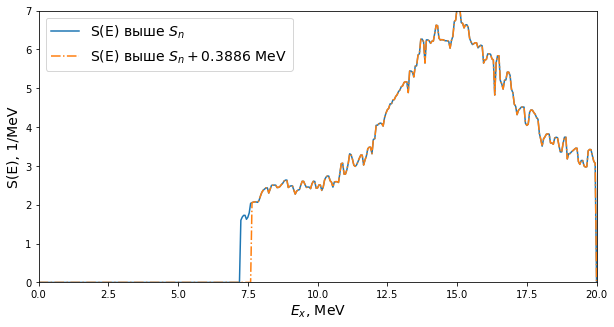

In [166]:
bgt_overSn = border_func2(decomp2['Ex, MeV'].values, decomp2['bgt'].values, S_n, decomp2['Ex, MeV'].values[-1])
bgt_over388Sn = border_func2(decomp2['Ex, MeV'].values, decomp2['bgt'].values, S_n+0.3886, decomp2['Ex, MeV'].values[-1])

plt.figure(figsize=(10,5))
plt.plot(decomp2['Ex, MeV'].values, bgt_overSn, label='S(E) выше $S_n$')
plt.plot(decomp2['Ex, MeV'].values, bgt_over388Sn, ls= '-.', label='S(E) выше $S_n+0.3886$ MeV')
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.legend( fontsize=14)
plt.xlim(0,20)
plt.ylim(0,7)

In [162]:
sigma_bgt_overSn_temp = [cross_sec(0,p, sigma_k_GTR, decomp2['Ex, MeV'].values, 
                                   bgt_overSn, 200) for p in p_list]
sigma_bgt_overSn_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_bgt_overSn_temp)

sigma_bgt_over388Sn_temp = [cross_sec(0,p, sigma_k_GTR, decomp2['Ex, MeV'].values, 
                                   bgt_over388Sn, 200) for p in p_list]
sigma_bgt_over388Sn_full = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_127Xe, 
                                  fp=sigma_bgt_over388Sn_temp)

In [163]:
overSn = rate_calc(sigma_bgt_overSn_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt)')
over388Sn = rate_calc(sigma_bgt_over388Sn_full, BS05OP_flux, Energy_all_fluxes, 
                step_all_fluxes, name='R-total (график bgt)')
overSn['Total'], over388Sn['Total'] 

(5.494887560424817, 4.333664280127627)

In [164]:
over388Sn['Total'] / overSn['Total'], 1 - over388Sn['Total'] / overSn['Total']

(0.7886720578851272, 0.21132794211487282)

In [167]:
output_table3 = pd.DataFrame(data=[], columns=['name','Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 
                                              'pp',  'Total'])
output_table3 = output_table3.append(over388Sn, ignore_index=True)
    
for elem in ['Be', 'f17', 'b8', 'n13', 'pep', 'o15', 'hep', 'pp',  'Total']:
    output_table3[elem] = output_table3[elem].round(3)
output_table3

,name,Be,f17,b8,n13,pep,o15,hep,pp,Total
0,R-total (график bgt),0.0,0.0,4.256,0.0,0.0,0.0,0.077,0.0,4.334
